# CT Images Denoising - Synthetic Images

Description of the jupyter notebook and maybe brief overview of the all project.

**Authors:** [Raphaël Achddou](https://people.epfl.ch/raphael.achddou) ([contact](mailto:raphael.achddou@epfl.ch)), [Paulo Ribeiro](https://people.epfl.ch/paulo.ribeirodecarvalho) ([contact](mailto:paulo.ribeirodecarvalho@epfl.ch))

## Import
Let's first import all libraries needed for the production of synthetic images using dead leaves.

In [1]:
import matplotlib.pyplot as plt

from utils import load_data
from skimage.morphology import disk, ellipse, square
from dead_leaves_generator import *

%load_ext autoreload
%autoreload 2

## Load Data

To create meaningful synthetic images, we made them statistically equivalent to real images. Then, samples of real CT images are needed.

In [2]:
# ~1min45s to load all 33'256 images
data_path = 'data_stats_analysis'
data = load_data(data_path)

  0%|          | 0/33256 [00:00<?, ?it/s]

Path:
 data_stats_analysis/train/1mm B30/quarter_1mm/L286/L286_QD_1_1.CT.0003.0172.2015.12.22.18.21.34.776739.358388650.IMA
Category:  train
Type:      1mm B30
Dose:      quarter
Patient:   L286


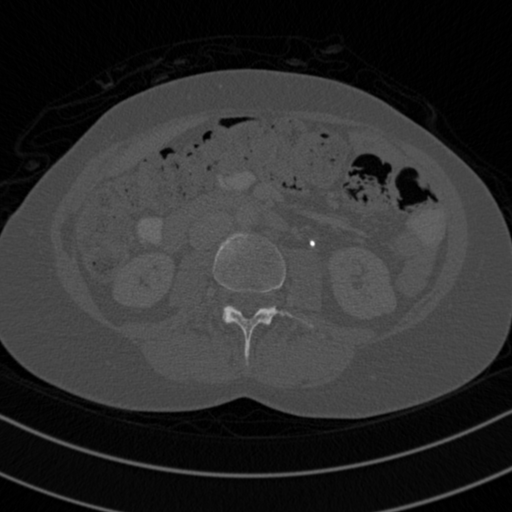

In [3]:
# TODO: (REMOVE) play with idx to check if the loading works properly
idx = 30000
print("Path:\n", data.imgs[idx].path)
print("Category: ", data.imgs[idx].cat)
print("Type:     ", data.imgs[idx].type)
print("Dose:     ", data.imgs[idx].dose)
print("Patient:  ", data.imgs[idx].patient)
data.imgs[idx].pil

We can now have a look at each patient and each projection of the training images, but for computation purpose, let's focus on one specific batch.

In [4]:
reduce = False

# If reduce set to True, let's only look at one specific patient for computation reasons
if reduce:
    data = data.filter(img_type=['3mm B30'],
                       patient=['L506'])

# Separate full and quarter dose images
data_fd = data.filter(dose=['full'])
data_qd = data.filter(dose=['quarter'])

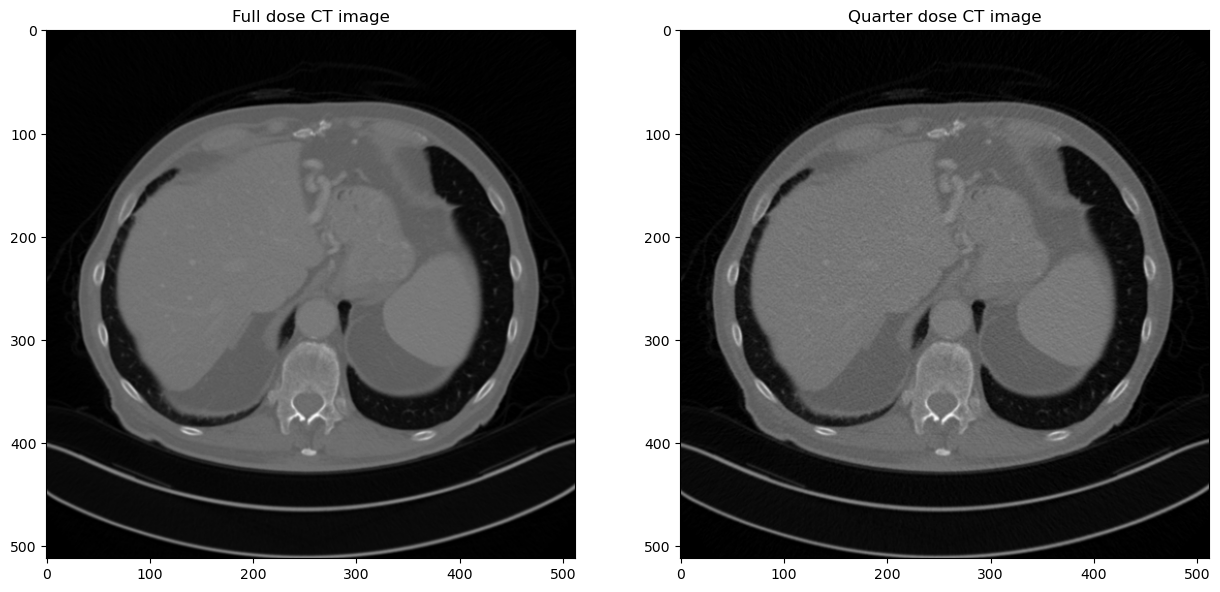

In [5]:
idx = 20  # select one of the 250 projection of patient L506 or 16'628 images if full data

# Display the CT images to have a quick overview
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

axs[0].imshow(data_fd.imgs[idx].pil, cmap='grey')
axs[0].set_title('Full dose CT image')
axs[1].imshow(data_qd.imgs[idx].pil, cmap='grey')
axs[1].set_title('Quarter dose CT image')

plt.show()

## Statistical Analysis of Real CT Images

As mention above, a statistical analysis from the real CT images need to be done to replicate the statistics in our synthetic images. We will focus on these following stat metrics :

1) color distribution
2) morphological analysis
3) noise analysis

### Color Distribution

Let's start by analyzing the color distribution of our real CT images. It is doing in a straightforward and easy manner by computing the histogram of the pixel intensities across all CT images from all patient.

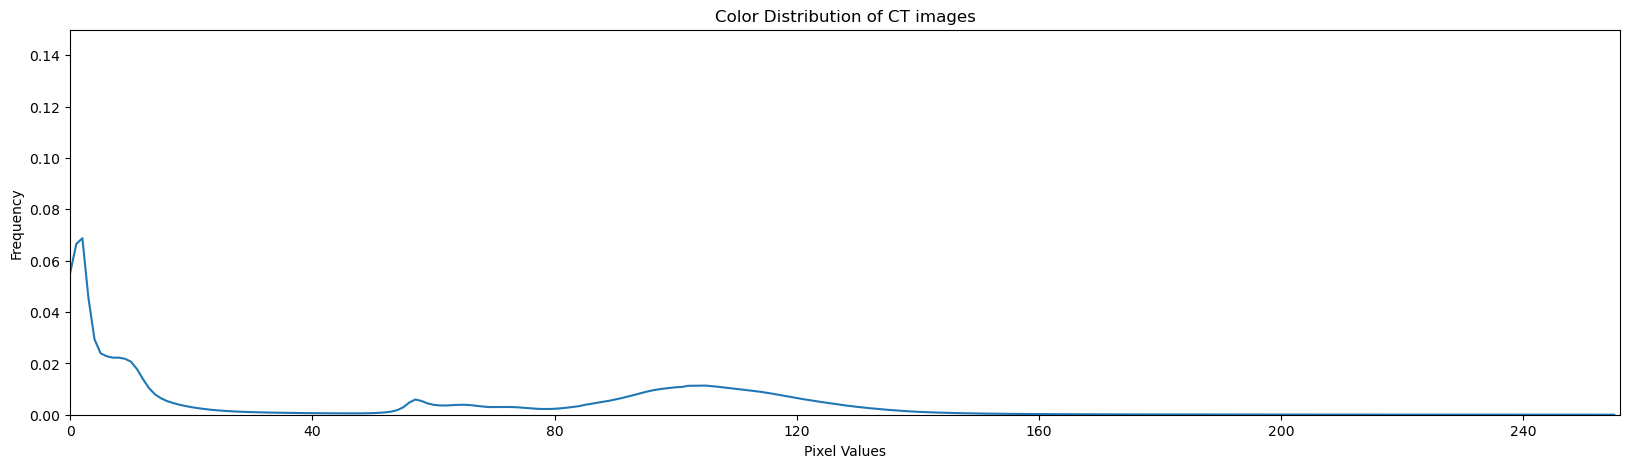

In [5]:
# Color distribution of full CT images
pixel_values_f, color_dist_f = data_fd.color_histogram(plot=True)

In [6]:
# Color distribution of quarter CT images
pixel_values_q, color_dist_q = data_qd.color_histogram(plot=True)

### Morphological Analysis

We make sure that our synthetic images follows the same morphological pattern. We then analysis which object is better to use during dead leaves generation and also which size of the object is preferred.

#### Object to Use

Useful documentation for [morphological](https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html#sphx-glr-auto-examples-applications-plot-morphology-py) analysis, fourier transform, ...

To do so, compute some erosion and dilation images using different object (circle, square, line, ...) and compare them to the original image. The most similar transformed image will give us which object to use.

In [7]:
# These arguments are set to have the same "size" to compare them fairly
args = {'disk': {'radius': 2,
                 'dtype': np.uint8,
                 'strict_radius': True},
        'ellipse': {'width': 1,
                    'height': 2,
                    'dtype': np.uint8},
        'square': {'width': 5,
                   'dtype': np.uint8}}

# Set the morphologies you want to test then
morphologies = {'disk': disk(**args['disk']),
                'ellipse': ellipse(**args['ellipse']),
                'square': square(**args['square'])}

# Compute the analysis
results = data_fd.morphological_analysis(morphologies)
display(results)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16628 [00:00<?, ?it/s]

  0%|          | 0/16628 [00:00<?, ?it/s]

  0%|          | 0/16628 [00:00<?, ?it/s]

ssim_opening_avg  ssim_closing_avg
disk             0.835951          0.896149
ellipse          0.817059          0.888095
square           0.774929          0.865226

We will use Structural Similarity Index (SSIM) to compare similarity between images.

#### Size of Object

To have this information, few ways are possible.

1) Directional Gradient Histogram
2) Fourier Transformation

##### 1) Directional Gradient Histogram

Here we basically compute the difference between each neighbour pixels (for each direction) and compute its histogram. Then we try to fit a Laplace distribution on it.

$e^{-\alpha|x|}$

This way, we find hthe $\alpha$ value that will give us information on the size of the object to use.

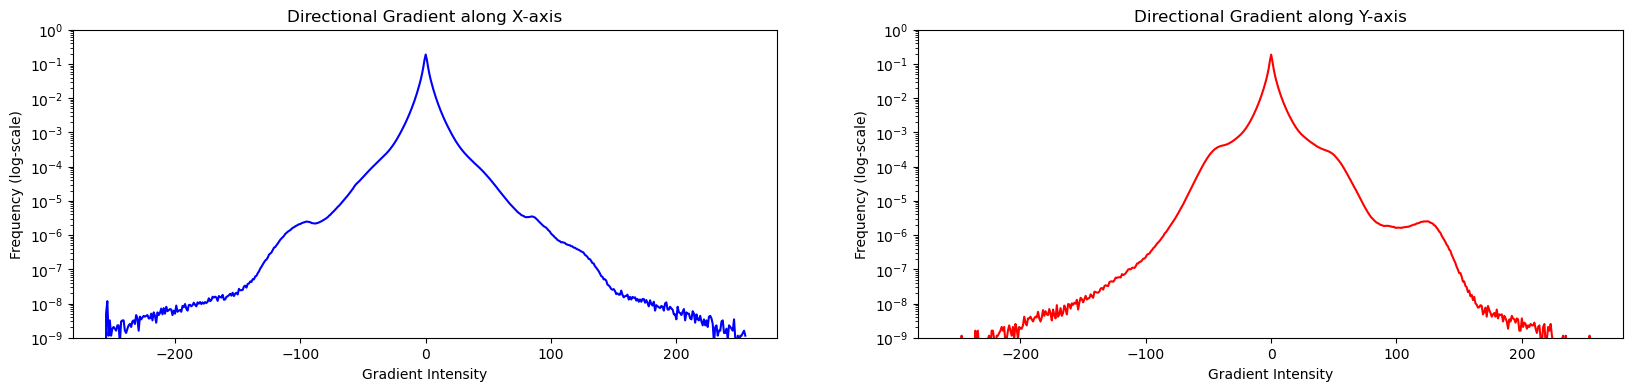

In [8]:
# let's select one image to create function that compute distribution of directional gradient histogram
grad_dist_x, grad_dist_y, grad_intensity = data_fd.directional_gradient(plot=True)

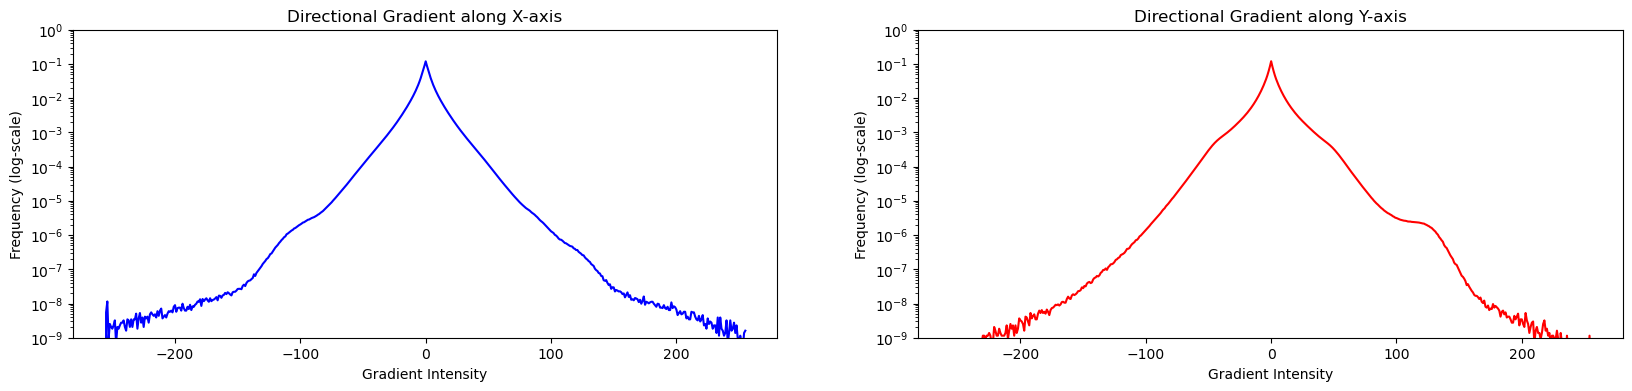

In [9]:
histo_x, histo_y, bins = data_qd.directional_gradient(plot=True)

##### 2) Fourier Transformation

Compute the Fourier transform of images and look at the y and x-axis (middle to positive) of this 3D graph (2D for the image dimension and the third with the fourier value at this point). The slope of the log plot will be interesting. Don't know why at the moment.

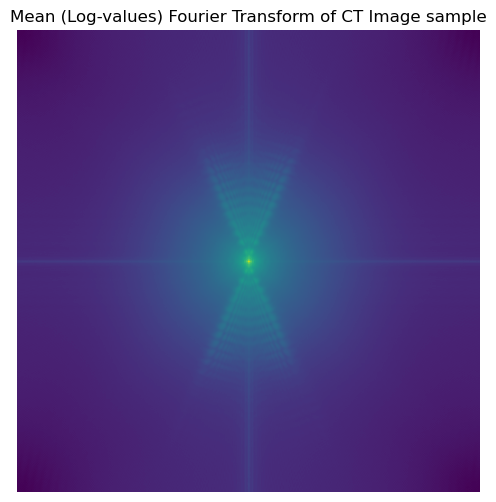

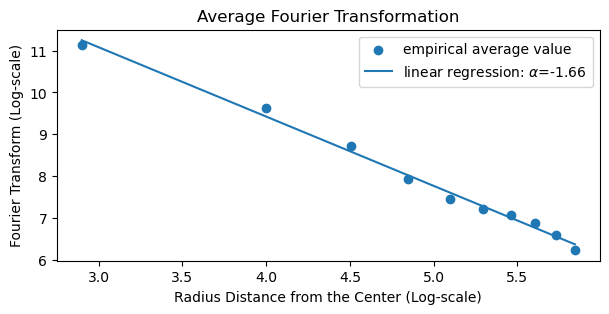

In [7]:
alpha = data_fd.fourier_transform_analysis(plot=True)

### Noise Analysis

Use the full and quarter dose projection, respectively FD and QD, to empirically compute the noise distribution. This way, we will be able to add some noise on our synthetic images to be able to train our model later on.

We will analyze the noise by level of grey, meaning that we compute the mean and standard deviation of a pixel value between its full and quarter dose image. Then, plot the standard deviation values by their grey level and compute the linear regression of all that. Then, intercept and slope will be our noise Poisson parameters.

In [ ]:
all_dict, noise_density_distribution, slope = data.noise_stat_analysis(plot=True)

In [ ]:
# TODO: (Delete) Just to show the pixel noised values distribution for a specific pixel intensity
pixels_intensity = np.arange(start=10, stop=255, step=50)

plt.figure(figsize=(15, 5))

for pixel_intensity in pixels_intensity:
    density, intensities = noise_density_distribution[pixel_intensity]
    plt.plot(intensities, density, label=f'Intensity: {pixel_intensity}')
    plt.axvline(x=pixel_intensity, color="r")

plt.xlabel('Intensity')
plt.ylabel('Density')
plt.title('Noise Density Distribution')
plt.legend()
plt.show()

## Store Analysis Results

In [7]:
ct_stat_results = {
    'alpha': -1.6678,
    'color_distribution': color_dist_f,
    'noise_density_distribution': noise_density_distribution,
    'noise_var_dict': all_dict[0]
}

np.savez('data_stats_analysis/ct_stat_results', **ct_stat_results)

## Synthetic Images Generation

Now, let's compute our synthetic images using our knowledge from the real CT images.

### Adding noise to Dead Leaves Images

From previous analysis we add the same noise from real CT Images to the synthetic Dead Leaves Images.

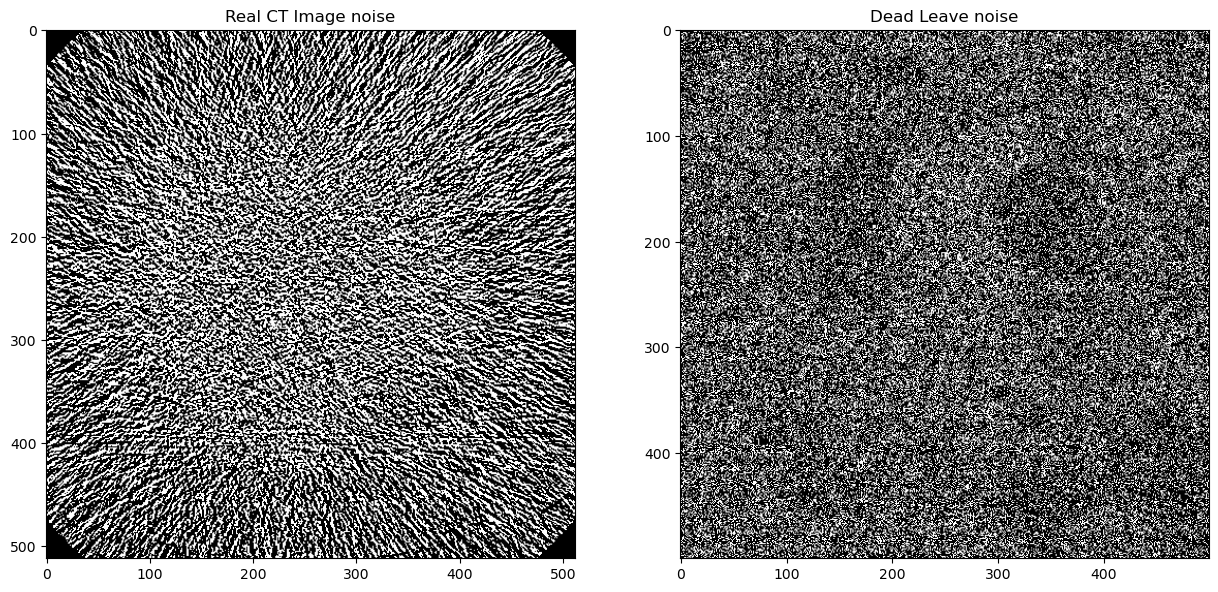

In [29]:
# I keep these ouptuts for my midterm presentation

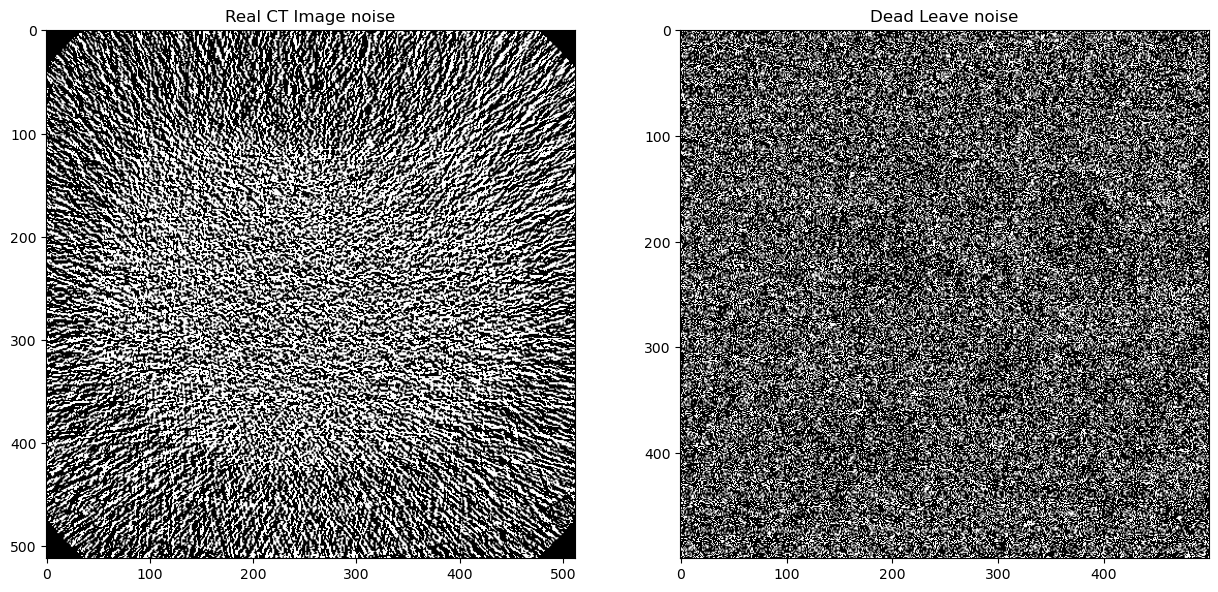

In [35]:
# I keep these ouptuts for my midterm presentation